# iLykei Lecture Series 

# Machine Learning

# Random Forests 

# Workshop

## Y.Balasanov, L.Nazarov &copy; iLykei 2017-24


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import string
from numpy.random import normal,random,seed
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import log_loss

# Review of bagging and random forests       

## Bagging

Leo Breiman in Technical Report No. 421 (1994) [Bagging Predictors](https://www.cs.princeton.edu/courses/archive/fall08/cos402/readings/bagging.pdf) proposed to improve the decision trees performance by combining results of several trees built on randomly generated training subsets.     
This method was called Bagging (Bootstrap AGGregating).  

Denote

* $X$ - set of objects;
* $Y$ - either finite set of classes (classification) or set of real numbers (regression);
* $f: X\rightarrow Y$;
* $L = {(x_1,f(x_1)),..,(x_m,f(x_n))}$ - learning sample;
* $B^p = \{ L_1,...,L_p \}.$ - set of new learning samples each of size $n$, drawn from $L$ by sampling uniformly and with replacement.  

Each learning sample $L_i$ generates predictor (tree) $\widehat{f}_i$. In case of regression simple averaging gives aggregated predictor 
$$
\widehat{f}(x)=\frac{1}{p}\sum_{i=1}^{p}\widehat{f}_{i}(x).
$$
A popular method of aggregating for classification problem is majority voting. Let
$$N_{y}(x)=\sum_{i=1}^{p}I_{\left( \widehat{f}_{i}(x)=y\right) },$$
where $I_A$ is the indicator of set $A$. The formula for aggregating predictor is
$$
\widehat{f}(x)= \underset{y\in Y}{\operatorname{argmax}}N_{y}(x).
$$
This bootstrapping procedure leads to better model performance because it decreases the variance of the model, without increasing the bias.   
This means that while the predictions of a single tree are highly sensitive to noise in its training set, the average of many trees is not, as long as the trees are not correlated.     
But if one or a few features happen to be very strong predictors for the response variable, these features will be selected in many of the trees, causing them to become correlated. Random forest method can overcome this disadvantage.

## Random Forests

Random Forest is a machine learning method capable of performing both regression and classification tasks.    

It also can be used as dimensionality reduction method.    

The [*sklearn.ensemble*](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) module includes two averaging algorithms based on randomized decision trees: the RandomForest algorithm and the Extra-Trees method. Both algorithms are perturb-and-combine techniques ([see here](https://www.stat.berkeley.edu/~breiman/arcall.pdf)) specifically designed for trees. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.  

Random forests provide an improvement over bagged trees by decorrelating trees when the impose constraints on predictors.   
     
As in bagging, a number of decision trees is built on bootstrapped learning samples.     
But when building these decision trees, each time a split in a tree is considered, a random sample of $m$ predictors is chosen as split candidates from the full set of $M$ predictors.    
The split is allowed to use only one of those $m$ predictors.     
Here is more detailed description of the algorithm.

1. Assume that  the size of the learning set $L$ is $n$ as above.    
Then, bootstrapped sample is generated from $L$ by sampling uniformly and with replacement.    
This sample will be the training set for the tree.
2. If there are $M$ input variables, a number $m<M$ is specified such that at each node, $m$ variables are selected randomly out of $M$.    
The best split on these $m$ is used to split the node.     
The value of $m$ is held constant through the process of growing the forest.      
3. Algorithm builds $N_{tree}$ trees. Each of them is grown to the largest extent possible and  there is no pruning.    
4. Predict new data by aggregating the predictions of the $N_{tree}$ trees (i.e., majority votes for classification, average for regression).

The value of $m$ is taken small compare to $M$. The inventors make the following recommendations:     

* For classification, the default value for $m$ is $\sqrt{M}$  and the minimum node size is one.  
*  For regression, the default value for $m$ is $M/3$ and the minimum
node size is five.  

In practice the best values for these parameters will depend on the problem, and they should be treated as tuning parameters.

Random forest can handle large data set with higher dimensionality. It can handle thousands of input variables and identify most significant variables so it is considered as one of the dimensionality reduction methods. Further, the model outputs Importance of variable, which can be a very handy feature.  

It has an effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing. It has methods for balancing errors in data sets where classes are imbalanced.  

Random Forest involves sampling of the input data with replacement.  Here around one third of the data are not used for training and can be used for testing.     
These observations are called out-of-bag (OOB) samples.    
Errors estimated on these OOB samples are known as OOB errors. The resulting OOB errors are valid estimates of the test error for the bagged model, since the response for each observation is predicted using only the trees that were not fit using that observation.    
An OOB error estimate is close to that obtained by 3-fold crossvalidation. Hence unlike many other nonlinear estimators, random forests can be fit in one sequence, with cross-validation being performed along the way.

Random Forest is better at classification but not as good for regression problems since it does not give continuous output.  

It looks like a black box approach to statistical modelers - you have very little control on what the model does.    
You can at best - try different parameters and random seeds.

# Regression

## Example: Predicting Baseball Players' Salaries

Use the Hitters data from the ISLR library for a simple example

In [2]:
URL = 'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Hitters.csv'

Remove missing entries and take logs

In [3]:
# Read and remove incomplete cases 
Hitters = pd.read_csv(URL,index_col=0).dropna()
# log transform Salary to make it a bit more normally distributed
Hitters['Salary'] = np.log(Hitters.Salary)
Hitters.head(3)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,6.163315,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,6.173786,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,6.214608,N


### Random Forest  regression     

Random forest [regression](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) is implemented in the [*sklearn.ensemble*](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) module.     

A random forest is a meta estimator that fits a number of decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if *bootstrap=True* (default).  

This implementation does not work with categorical features. Replace them with integer ones using class [*sklearn.preprocessing.LabelEncoder*](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [4]:
le = LabelEncoder()
for col_name,col_type in zip(list(Hitters),Hitters.dtypes):
    if col_type=='object':
        print('encode column',col_name)
        Hitters[col_name] = le.fit_transform(Hitters[col_name])   
Hitters.head(3)

encode column League
encode column Division
encode column NewLeague


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,6.163315,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,6.173786,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,6.214608,1


#### Default arguments    

Set seed for reproducibility and grow a forest.

In [5]:
# oob_score: whether to use out-of-bag samples to estimate the R^2 on unseen data 
# n_jobs=-1: the number of jobs is set to the number of cores
rfSalary = RandomForestRegressor(n_estimators=500,random_state=0,
                                 oob_score=True,
                                 n_jobs=-1)
X, y = Hitters.drop('Salary',axis=1),Hitters.Salary
rfSalary.fit(X, y)
print('coefficient of determination R^2 =',rfSalary.oob_score_)

coefficient of determination R^2 = 0.7570025817947998


The `RandomForestRegressor` class instance has attribute  
`feature\_importances\_ : array of shape = (n_features,)`.  
The higher feature importance, the more important is the feature.

In [6]:
print(rfSalary.feature_importances_)

[0.03887115 0.04079394 0.01082699 0.01939749 0.0298337  0.03659159
 0.01130996 0.38249288 0.11890794 0.02206307 0.16701218 0.04776389
 0.03200204 0.00126962 0.00158199 0.01961315 0.00827203 0.00904423
 0.00235216]


We can also sort variables according to its importances and plot them

<Axes: >

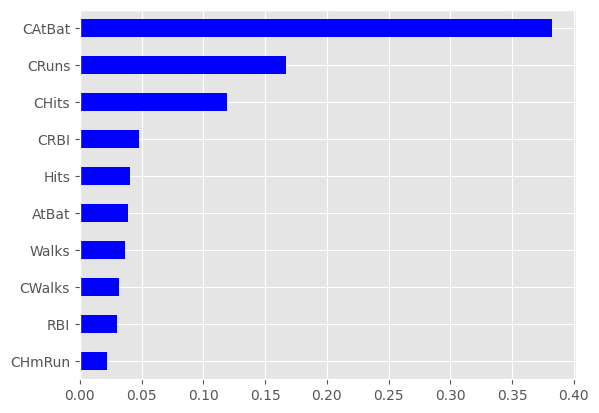

In [7]:
imp = pd.Series(rfSalary.feature_importances_, 
                index=list(X)).sort_values()
imp[-10:].plot(kind = 'barh', color='blue')

#### Reduced number of trees
Compare forests with 500 and 200 trees:

In [8]:
rfSalary200 = RandomForestRegressor(n_estimators=200,
                                    random_state=0,oob_score=True,
                                    n_jobs=-1)
rfSalary200.fit(X, y)
print('T200 R^2 =',rfSalary200.oob_score_)
print('T500 R^2 =',rfSalary.oob_score_)

T200 R^2 = 0.7601575008623296
T500 R^2 = 0.7570025817947998


Does the relative importance change?

In [9]:
imp200 = pd.Series(rfSalary200.feature_importances_, 
                   index=list(X)).sort_values()
# reverse to show important features first
pd.DataFrame({'T200':imp200.index,'T500':imp.index})[::-1]

,T200,T500
18,CAtBat,CAtBat
17,CRuns,CRuns
16,CHits,CHits
15,CRBI,CRBI
14,Hits,Hits
13,CWalks,AtBat
12,Walks,Walks
11,AtBat,CWalks
10,RBI,RBI
9,CHmRun,CHmRun


#### Variation of number of variables in split

[0.7442778311539155, 0.7750295728054246, 0.7726048835542285, 0.7773888705964926, 0.7672287600339333, 0.7749215143564506]


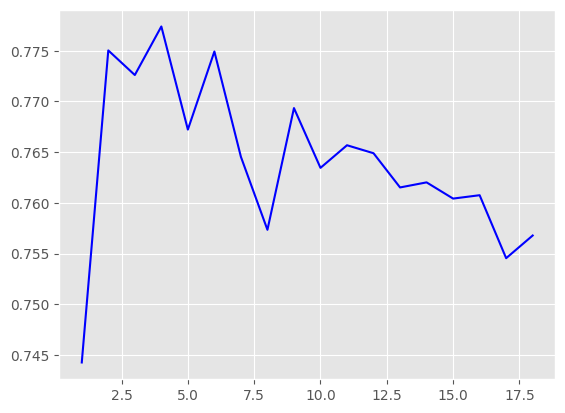

In [10]:
max_features_quality = [RandomForestRegressor(n_estimators=200,
                                              random_state=0,
                                              oob_score=True,
               n_jobs=-1,max_features=i).fit(X,y).oob_score_ 
               for i in np.arange(1,X.shape[1])]

print(max_features_quality[:6])
plt.plot(np.arange(1,X.shape[1]),max_features_quality, color='blue')

Plotting the curves for different numbers of variables at each split suggests to use parameter `max_features` equal to 6.    

#### Predicting and calculating RMSE for the random forest model.

In [11]:
def RMSE(x,y): 
    return np.mean((x - y)**2)**0.5
rfSalary200 = RandomForestRegressor(n_estimators=200,random_state=0,
                                    oob_score=True,n_jobs=-1,
                                    max_features=6)
rfSalary200.fit(X, y)
print('train RMSE =',RMSE(Hitters.Salary,rfSalary200.predict(X)))

train RMSE = 0.15244572792480246


Note that it is prediction for the train set. Out-of-bag RMSE is more adequate estimate of the model quality.

In [12]:
print('OOB RMSE =',RMSE(Hitters.Salary,rfSalary200.oob_prediction_))

OOB RMSE = 0.42105177264343685


## Example: Large Number of Predictors

Consider the example analyzed in the workshop Linear Regression with Large Number of Predictors. Simulate data

In [13]:
N = 500
np.random.seed(0)
Epsilon = np.random.normal(size=N)
X = pd.DataFrame(np.random.normal(0, 2, size=(N,N))).add_prefix('X')
slopesSet = np.random.uniform(1,3,N)
Y = [1 + X.iloc[:,:z] @ slopesSet[:z] + Epsilon for z in np.arange(1,N)]
X.head(5)
m = 440
X,y = X.iloc[:,:m],Y[m-1]

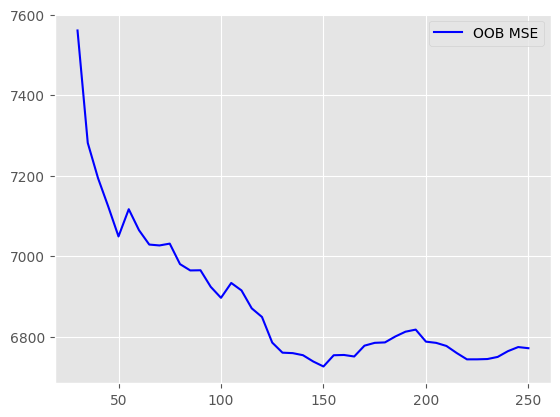

In [14]:
# set warm_start=True to reuse the solution of the previous call to fit
rfManyReg = RandomForestRegressor(warm_start=True,random_state=0,
                                  oob_score=True, n_jobs=-1)
min_estimators = 30
max_estimators = 250
step = 5
est_range = np.arange(min_estimators, max_estimators + 1,step)
error_rate = np.zeros((max_estimators-min_estimators)//step+1)

for i in est_range:
    rfManyReg.set_params(n_estimators=i)
    rfManyReg.fit(X, y)
    error_rate[(i-min_estimators)//step] = RMSE(y,
                                                rfManyReg.oob_prediction_)**2   
        
plt.plot(est_range,error_rate, color = 'blue')
plt.legend(['OOB MSE'])

Seems like 150 trees is quite enough for the model. In the previous lectures we got 10 fold cross validation MSE for linear model about 45 and for regression tree it was above 13000. Calculate the score for random forest.

In [15]:
rf150 = RandomForestRegressor(random_state=0,n_estimators=150,n_jobs=-1)
print ('Random Forest Regressor model CV MSE = ',
       -np.mean(cross_val_score(rf150, X, y,
                                scoring='neg_mean_squared_error',
                                cv=10)))

Random Forest Regressor model CV MSE =  6944.099343652687


Significant improvement compare to regression tree but far behind the linear model.   

#### Importance of predictors

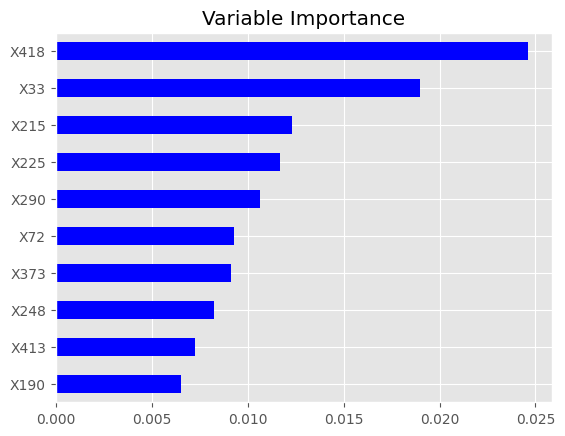

In [16]:
imp = pd.DataFrame({'importance':rfManyReg.feature_importances_,
                    'slope':slopesSet[:m]},
                   index=list(X)).sort_values('importance')
imp[-10:].importance.plot(kind = 'barh', color = 'blue')
_ = plt.title('Variable Importance')

Check if importance of variables is explained by the value of the simulated betas. Calculate empirical copula.

<Axes: xlabel='importance_rank', ylabel='slope_rank'>

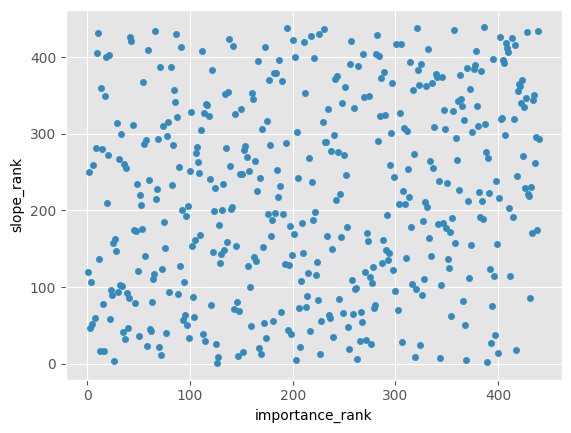

In [17]:
imp['importance_rank']=imp['importance'].rank()
imp['slope_rank']=imp['slope'].rank()
imp.plot(x='importance_rank',y='slope_rank',kind='scatter')

The empirical copula shows independence of the importance index and the betas used in simulation.

In [18]:
np.column_stack((np.argsort(imp.importance),
                 np.argsort(imp.slope)))[-6:]

array([[434,  65],
       [435, 356],
       [436, 229],
       [437, 320],
       [438, 193],
       [439, 385]])

Recall that all parameters are simulated as significant and all predictors are independent by construction.     
The larger the coefficient - the more significant should be the predictor.     
Random tree may not be assigning importance correctly in this case.    

# Classification

## Otto Product Classification Example

In this example we use data set provided by **Otto Group** for **Kaggle** competition [Otto Group Product Classification Challenge](https://www.kaggle.com/c/otto-group-product-classification-challenge).      

Otto Group needed categorizing about 200,000 unspecified products into 9 classes based on 93 unspecified features. For simplicity we reduced the number of visitors and the number of classes.     

Load the data set.

In [19]:
Data = pd.read_csv('DTTrain.csv')
Data.shape # dataset dimensions
# data content
Data.head()

,time,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,45652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Class_5
1,225646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Class_3
2,345735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,Class_5
3,436478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Class_5
4,478129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Class_5


Encode labels of target column and partition data into train (2/3) and test (1/3) sets.

In [20]:
X = Data.drop(['time','target'],axis=1)
y = LabelEncoder().fit_transform(Data.target)
xTrain, xTest, yTrain, yTest = train_test_split(X, y,test_size=1/3, 
                                                random_state=0)

Fit random forest to the train data and make prediction on the test data.

In [21]:
rfOtto = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1)
rfOtto.fit(xTrain,yTrain)
rfPred = rfOtto.predict_proba(xTest,)
rfPred[1:5]

array([[0.04, 0.16, 0.03, 0.69, 0.08],
       [0.06, 0.66, 0.  , 0.04, 0.24],
       [0.04, 0.8 , 0.03, 0.07, 0.06],
       [0.  , 0.98, 0.  , 0.02, 0.  ]])

Use Multiclass logloss for estimating prediction quality. Calculate it for random forest.

In [22]:
rfLogLoss = log_loss(yTest, rfPred)
print('Random forest logloss',rfLogLoss)

Random forest logloss 0.39537975145332516
